<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Algoritmos_Gillespie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos de Gillespie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Método de siguiente reacción sin redes

In [2]:
def Gillespie_First_Reaction(N,X_S,X_I,beta,gamma,T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    Historia=[[0,X_S,X_I]]
    while(flag):
        tau=np.random.exponential(1/((beta/N)*X_S*X_I+gamma*X_I))
        p=np.random.uniform(0,1)
        if(p<(beta*X_S/N)/((beta/N)*X_S+gamma)):#Infeccion
            X_S+=-1
            X_I+=1
        else:
            X_I-=1
        t+=tau
        Historia.append([t,X_S,X_I])
        if(X_S==0 or X_I==0 or t>T):
            flag=False
    return Historia

### Ejemplo

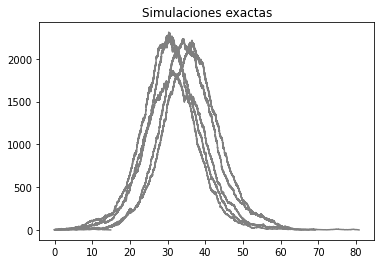

In [4]:
N=10**5
S_0=N-2
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    while(len(H)<10):
        H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR markoviano en redes

In [2]:
import networkx as nx

In [3]:
def update_dict_add(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.append(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [4]:
def update_dict_remove(dict_num_contacts,k,s_i):
    u= dict_num_contacts[k].copy()
    u.remove(s_i)
    dict_num_contacts[k]=u
    return dict_num_contacts

In [5]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)#Tiempo de siguiente reacción, hasta ahora desconocida.
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            k+=1
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
        #k es el número de contactos infecciosos del seleccionado.
        #Seleccionamos uno aleatoriamente de ese grupo
        new_reaction=np.random.choice(dict_num_contacts[k])
    else:#Recuperación
        k=-1
        #Seleccionar un infeccioso al azar.
        new_reaction=np.random.choice(X_I_indexes)
    return tau,new_reaction,k
#Monte_Carlo_Step_exp(Lambdas)

In [6]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]#Focus
    dict_num_contacts = dict.fromkeys(range(X_I+1),[])
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts=update_dict_add(dict_num_contacts,count_for_i,i)
    #print(dict_num_contacts)
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[k])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #print("tiempo generado",tau,new_reaction)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'
            X_I_indexes=np.append(X_I_indexes,new_reaction)
            #print('Infeccion actualizada')
            i=new_reaction
            #print(new_reaction,' infectado al tiempo ', tau, ' del grupo ', 'k=',k_choice)
            dict_num_contacts=update_dict_remove(dict_num_contacts,k_choice,i)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #print("Si removido")
            #Ahora a todos los individuos que tenian contacto con el nuevo infeccioso, les aumentamos un contacto infeccioso.
            num_max_cont=list(dict_num_contacts.keys())[-1]
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    #print('el vecino ', vecino, ' del nuevo infectado ', i,' tiene ', num_cont_del_vecino,' contactos')
                    if(num_cont_del_vecino+1>num_max_cont):
                        dict_num_contacts.update({num_cont_del_vecino+1:[vecino]})
                    else:
                        dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino+1,vecino)
                    #print('el vecino ', vecino, ' ya no tiene ', num_cont_del_vecino, ' asi que lo borramos')
                    dict_num_contacts=update_dict_remove(dict_num_contacts,num_cont_del_vecino,vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            X_I_indexes=np.delete(X_I_indexes,np.where(X_I_indexes == new_reaction))#Vale la pena pasarlo a lista para usar remove()?
            #print('Recuperacion actualizada')
            i=new_reaction
            #Hay que actualizar los números de contactos de los susceptibles que tenían contacto con este infeccioso.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# no hay vecinos
                    dict_num_contacts=update_dict_add(dict_num_contacts,num_cont_del_vecino-1,vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
        t+=tau
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        #print(X_S)
        #print(dict_num_contacts)
        if(X_I==0):
            flag=False
    return Historia
        #-------------------------------------------

### Ejemplo

In [7]:
N=10**3
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(10,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=5,replace=False)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'

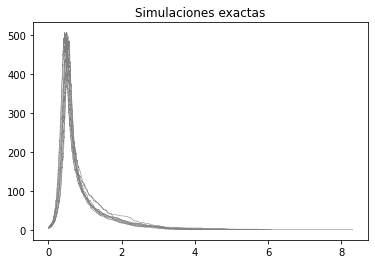

In [9]:
S_0=N-5
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=[]
    G_copy=G.copy()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=np.inf)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()

## Método directo para SIR no-markoviano.



## Ejercicio didáctico para no-markoviano

Supongamos $X_I$ individuos infectados. No hay dinámica de contagio. 

Caso 1. Aplicación de una vacuna. 

Por ejemplo, si conocemos que una vacuna se aplicará aleatoriamente según una distribución no exponencial.

Sea $\psi_R$ la f.d.p. de tiempos de inter-ocurrencia de recuperación (o aplicación de la vacuna). Naturalmente, aquí, el tiempo de la siguiente recuperación depende del tiempo de la última recuperación, sin embargo, este ejemplo es sencilo porque solamente hay un canal de reacción ($M=1$) porque el evento es: Aplicar vacuna aleatoriamente (la aplicación no considera el tiempo que llevas enfermo, es decir, no hay prioridad. El caso siguiente cubre ese caso).

Formalmente, sea $t_u$ el tiempo de la última recuperación. La condición inicial del sistema es $t_u=0$. 

Como sabemos, hace falta calcular $$\Phi(\tau)=\prod \limits_{j=1}^M \frac{\Psi_j(\tilde{t}_j +\tau) }{\Psi_j(\tilde{t}_j)},$$
donde $\Psi_j(t)$ es la función de supervivencia de la densidad $\psi_j$,
y resolver $\Phi(\tau)=u$ donde $u\sim U(0,1)$.

Como $M=1$, generar estos número es equivalente 
Caso 2. Una cuarentena super-efectiva.





## Explicación. 

Al igual que el caso Markoviano, tenemos dos posibles reacciones. Una infección y una recuperación. 

Duda: ¿La distribución de los tiempos dependen de la última vez que ocurrió una interacción? Suena a que sí, pero en el caso de una gráfica completa, que debería ser el equivalente, parece que no es necesario.
(Un escenario)

Sean $\phi_I$ y $\phi_R$ las f.d.p. de los tiempos de inter-ocurrencia de los eventos de infección y recuperación, respectivamente. 

En el caso markoviano se sabe que la distribución de los tiempos de inter-ocurrencia de infección dependen linealmente del número de individuos infecciosos en la población. Por ejemplo, en una población con $X_S$ individuos susceptibles y $X_I$ infecciosos, la tasa del proceso de Poisson que simula los contactos, y por lo tanto es el parámetro de una distribución exponencial (tiempos de inter-ocurrencia) es $\beta \cdot X_S\cdot X_I$, que coincide con el parámetro del mínimo de una colección de $X_S$ variables aleatorias independientes, cada una de distribución exponencial de parámetro $\lambda \cdot X_I$. 

Como en el caso no-markoviano esto no es necesariamente cierto, entonces para cada individuo susceptible, es decir, la colección de v.a. de distribuciones 

Ya me queda más clara la conexión entre markoviano y Ley de Acción de Masas. 


Supongamos una población de $X_S$ individuos susceptibles y $X_I$ individuos infecciosos, sin redes. Si nos concentramos en un individuo susceptible, como no hay red (es equivalente a que hay una red completa), tiene un posible contacto con cada uno de los infecciosos, con tasa instantánea $\beta$. Es decir, el tiempo de la siguiente infección con uno de estos infecciosos (seleccionado arbitrariamente) sigue una distribución exponencial de parámetro $\beta$, luego, el tiempo en el que tiene contacto con alguno de estos infecciosos (porque el mínimo de v.a. exponenciales independientes es exponencial de parámetro la suma de los parámetros) sigue una distribución exponencial de parámetro $\beta \cdot X_I$. Esto es para un susceptible cualquiera, así que el tiempo en el algún susceptible tiene contacto con algún infeccioso, por la misma propiedad; sigue una distribución exponencial de parámetro $\beta \cdot X_I\cdot X_S$.

In [ ]:
def pdf_Weibull(x,lammbda,a):
    # a=1 es una exponencial.
    return (a/lammbda)*(x/lammbda)**(a-1)*np.exp(-(x/lammbda)**a)
def survival_Weibull(x,lammbda,a):
    return np.exp(-(lammbda*x)**(a))

In [ ]:
def Phi(x,times_last_events):
    

In [ ]:
def get_event(t,X_s,X_I,times_last_events):
    

In [ ]:
def Gillespie_Direct_Method_NM(N,X_S,X_I,phi_I,phi_R,T=np.inf):
    #X_R=N-X_S-X_I
    #tiempo
    flag=True
    t=0
    Historia=[[0,X_S,X_I]]
    times_last_events=[0,0]#Infeccion, recuperacion, respect.
    while(flag):
        evento=get_event(t,X_S,X_I,times_last_events)
        if(evento=='Infeccion'):#Infeccion
            X_S+=-1
            X_I+=1
        else:
            X_I-=1
        t+=tau
        Historia.append([t,X_S,X_I])
        if(X_I==0 or t>T):
            flag=False
    return Historia

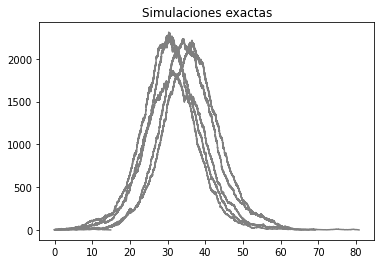

In [ ]:
N=10**5
S_0=N-2
I_0=N-S_0
beta=1.25
gamma=1
for k in range(10):
    H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    while(len(H)<10):
        H=Gillespie_First_Reaction(N,S_0,I_0,1.25,1)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray')
plt.title('Simulaciones exactas')
plt.show()

### Ejemplo

## Método directo para SIS no-markoviano. (de ser posible)


## Método directo para SIR no-markoviano en redes

## Explicación. 
Para cada individuo "en riesgo", es decir, con al menos un posible contacto infeccioso, existe una colección de aristas que lo conectan con estos indiviudos infeccciosos.

Sea $E_I=\{e_1,\ldots, M_1\}$ el conjunto de aristas que involucran u individuo susceptible y uno infeccioso, es decir, $e_i=(v_{1i},v_{2i})$, sin pérdida de  generalidad, con $v_{1i}$ infeccioso y $v_{2i}$ susceptible.


Además, sea $V_R=\{v_{i_1},\ldots,v_{i_{X_I} }\}$ el conjunto de nodos infecciosos, donde $i_1 < i_2<\cdots<i_{X_I}$ es un ordenamiento del número de infecciosos $X_I(t)$

Ahora, definimos los canales de reacción como el conjunto de índices $\{1,\ldots, M\}$, donde $M=M_1+X_I$. De esta manera, las posibles reacciones corresponden a la infección de un individuo susceptible a través de una de las aristas que lo conectan a un idividuo infeccioso, así como la recuperación de un nodo infeccioso. 

A diferencia del algoritmo de Gillespie original, ni los contactos ni la recuperación de los individuos se simulan como procesos de Poisson, es decir, no suponemos que los tiempos inter-ocurrencia se distribuyen como exponenciales de parámetros $\beta$ y $\gamma$ respectivamente. En cambio, cada arista tiene asociada una distribución de tiempos de inter-ocurrencia, así como los tiempos de recuperación siguen una distribución propia, en principio, distintas a la exponencial. \\ 

En su forma más general, podríamos considerar $N+|E|$ distintas distribuciones, es decir, una para cada recuperación de un indiviuo, así como una distribución distinta para cada interacción entre dos individuos, es decir, una arista, de las cuales hay $|E|$. Para simplificar, podemos suponer que la población es homogénea, en el sentido de que cada individuo posee las mismas características y se comporta de la misma manera, y reducir el número de distribuciones consideradas a $2", es decir, una para los tiempos de infección a través de contacto por una arista, y otra para los tiempos de recuperación de nodos infecciosos.\\ 

